## Concise: 1: Start and mesh
Author: yanjun zhang, Source from book "Abali - 2017 - Computational Reality" P119

DOLFINx version: 0.8.0
Simulation environment setup complete.
1: Total braking tims is  48.05 s
2: Total numb steps is  62
The file 'm-3-20.msh' exists, start creat now:
DOLFINx version: 0.8.0
Simulation environment setup complete.

1: Progress: 8.6%. Use time:             17 s. Start: 2024-11-18 14:06:10.      


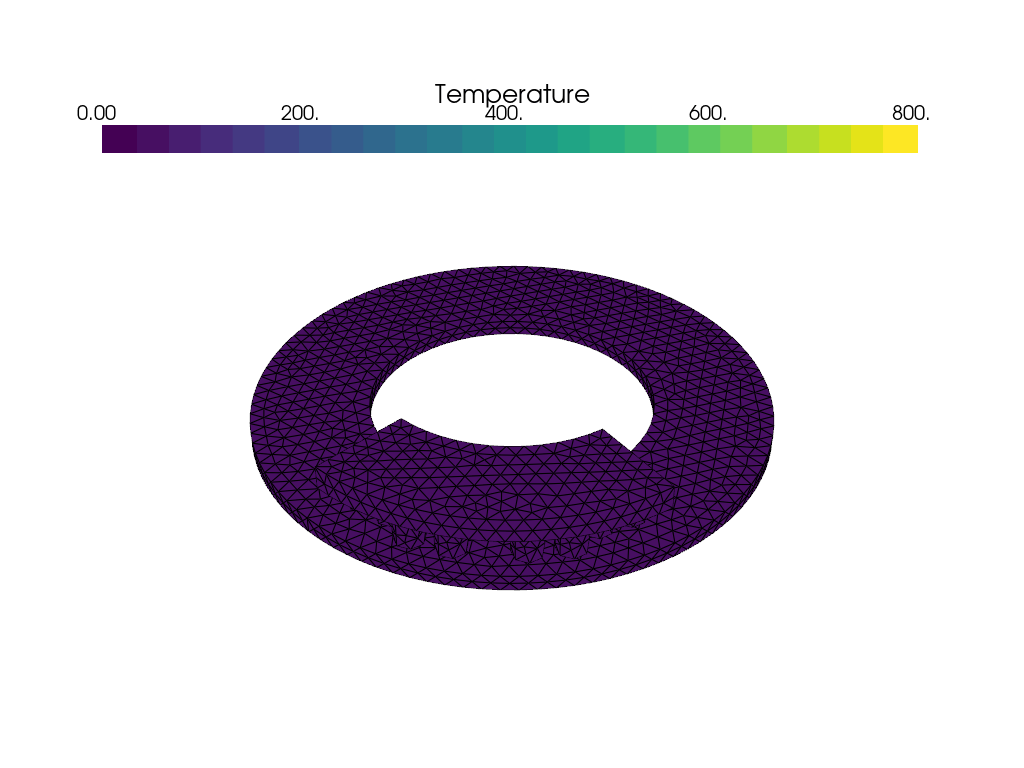

In [1]:
from disc_f1 import *

################################################################
def solve_heat(Ti, u, num_steps, dt, x_co, y_co, angular_r, \
               t_brake, domain, S_rub_circle, fdim,\
               rho, c, v, radiation, k, h, f, Tm, g,\
               ds, xdmf, b_con, bc, plotter, warped,\
               mesh_name1, mesh_brake, pad_v_tag, z4,\
               z1, x_co_zone, u_n ):
  
    T_array = [(0, [Ti for _ in range(len(u.x.array))])]
    total_degree = 0
    t = 0
    fraction_c = []
    for i in range(num_steps):
        
         t += dt[i]
         x_co, y_co = rub_rotation(x_co, y_co, angular_r) 
         total_degree += angular_r
    
         # Construct the message     
         end_time = time.time()
         elapsed_time = end_time - start_time
         elapsed_time1 = round(elapsed_time, 0)
         formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
         if elapsed_time1 >= 60:
            min = elapsed_time1 / 60;       hours = min / 60
            progress_message = f"1: Progress: {round(100 * (t / t_brake), 1)}%. Use time: \
            {round(hours)} hours {round(min)} min. Start: {formatted_start_time }."
         else:
            progress_message = f"1: Progress: {round(100 * (t / t_brake), 1)}%. Use time: \
            {round(elapsed_time1)} s. Start: {formatted_start_time }."
         sys.stdout.write(f"\r{progress_message.ljust(80)}")  # 80 spaces to ensure full clearing
         sys.stdout.flush()

        

         S_rub_circle1 = [353.44] *18  # It is not area, it should be r2. (x-x_co)2 + (y-y_co)2 = r2
         
         #####################################
         co_ind, fa_mar, so_ind   = target_facets( domain, x_co, y_co, S_rub_circle1 )
         facet_tag                = meshtags( domain, fdim, co_ind[ so_ind], fa_mar[ so_ind] )
         ds                       = Measure( "ds", domain=domain, subdomain_data=facet_tag)
         #print(co_ind)     

         F = ((rho * c) / dt[i] * inner(u, v) * dx
             + k * inner(grad(u), grad(v)) * dx
             + h * inner(u, v) * ds(200)
             + radiation * inner(u**4, v) * ds(200)
             - ( inner(f, v) * dx    # f is heat source, equal to 0.
                 + (rho * c) / dt[i] * inner(u_n, v) * dx  #u_n is value of last step u.
                 + h * Tm * v * ds(200)
                 + radiation * (Tm**4) * v * ds(200)) )

         for j in list(range(1, 19)):
             F += ( - inner(g[i], v) * ds(10 * j) 
                    - h * inner( u, v) * ds(10 * j)  
                    - radiation * inner( (u**4 - Tm**4), v) * ds(10 * j) )    

         u_pre_solve = u.copy()         

         problem = NonlinearProblem(F, u, bcs=[bc])
         ## 7: Using petsc4py to create a linear solver
         solver_setup_solve(problem, u)
        
         u.x.scatter_forward()            
       
         # Update solution at previous time step (u_n)
         u_n.x.array[:] = u.x.array
         T_array.append((t, u.x.array.copy()))
         # Write solution to file
         xdmf.write_function(u, t)
         # Update plot
         #warped = grid.warp_by_scalar("uh", factor=0)
         plotter.update_coordinates(warped.points.copy(), render=False)
         plotter.update_scalars(u.x.array, render=False)
         plotter.write_frame()      

         #print('Rub radius is ', r_rub_new)

    plotter.close()
    xdmf.close()
    print()
    return(T_array, fraction_c )
###########################################################


# mesh-size, contact area coefficient
mesh_min, mesh_max = 3, 20
c_contact          = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r          = 2240
v_vehicle, c_acc   = 160, 1
z1,z2,z3,z4,z_all  = 20,33,30,83,50
pad_v_tag          = 32

# calling local functions to get all parameters
(dt, P, g, num_steps, h, radiation, v_angular, \
 Ti, Tm, S_rub_circle_ini, t, rho, c, k, t_brake, 
S_total,)                                       = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)
print("1: Total braking tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)

#g = g*500

## here use lots of abbreviation, details are in disc_f
domain, cell_markers, facet_markers, mesh_name, mesh_name1, mesh_name2 \
                       = mesh_brake_all(mesh_min,mesh_max,pad_v_tag)

V, T_init, u_n         = initial_u_n(domain, Ti)  ## not solve, only give all Ti to u_n

fdim, bc, mesh_brake, all_e,xdmf, x_co, y_co, ds, b_con \
                       = mesh_setup( domain, V, mesh_name1, num_steps, \
                         angular_r, mesh_name2, c_contact, z_all, Tm, S_rub_circle_ini)
# Initialize
problem,u,v,f,n_vector = variation_initial(V, T_init, domain, rho, c, b_con,\
                          radiation, h, k, xdmf, dt, ds, u_n, Tm, g, bc);

solver_setup_solve(problem,u)

## Visualization of time dependent problem using pyvista
gif_name    = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, angular_r, mesh_name2, c_contact, all_e)
plotter, sargs, renderer, warped, viridis, grid = plot_gif(V,u,gif_name)

#num_steps= int(num_steps)
num_steps= int(10)

###################################################################
x_co_zone = 0.05
## here u already changed from 60. u_n is till 60.
T_array,fraction_c  = solve_heat(Ti, u, num_steps, dt, x_co, y_co, angular_r, \
               t_brake, domain, S_rub_circle_ini, fdim,\
               rho, c, v, radiation, k, h, f, Tm, g,\
               ds, xdmf, b_con, bc, plotter, warped,\
               mesh_name1, mesh_brake, pad_v_tag, z4,\
               z1, x_co_zone, u_n)  #last u should be u_n, here we set u, \
#the same with previous:solver_setup_solve(problem,u)
####################################################################


from IPython.display import display, Image
display(Image(gif_name))